# library

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
import os

# Function

In [2]:
def ShowImage(title,img,ctype):
  plt.figure(figsize=(9, 9))
  if ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

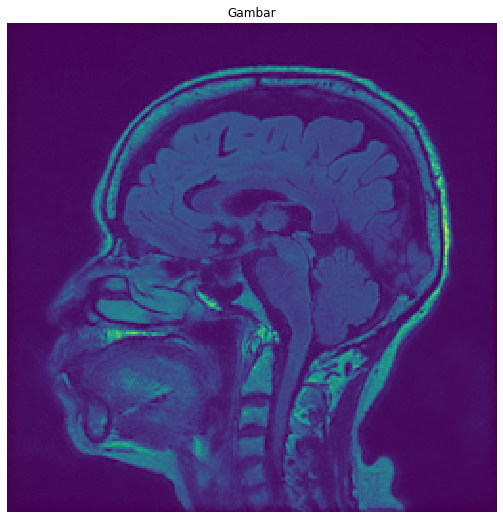

In [3]:
basepath ="../dicom/"
d = pydicom.read_file(basepath + "Z519")
file = np.array(d.pixel_array)
img = file
ShowImage('Gambar',img,'rgb')

In [4]:
img_2d = img.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

# Gaussian thresholding

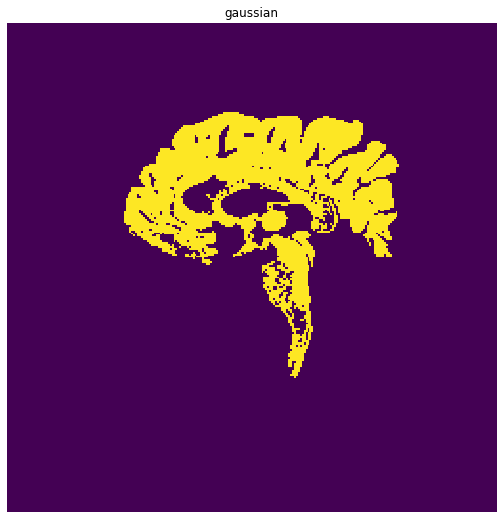

In [6]:
gaussian = cv2.adaptiveThreshold(hasil,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,115, 1)

foreground_value = 255
mask_gaussian = np.uint8(gaussian == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask_gaussian, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
gauss = np.zeros_like(gaussian)
gauss[labels == largest_label] = foreground_value
ShowImage('gaussian',gauss,'rgb')

# invers gauss

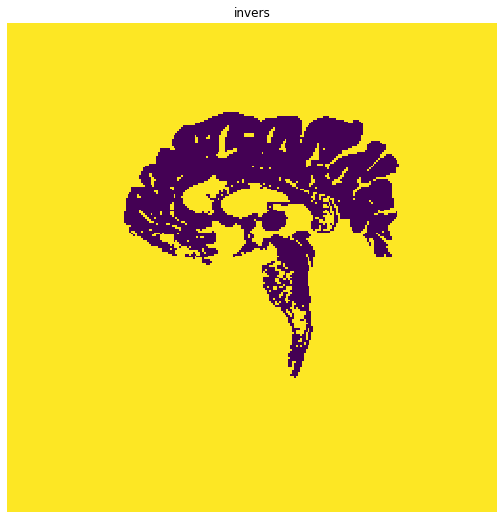

In [7]:
invers = cv2.bitwise_not(gauss)
ShowImage('invers',invers,'rgb')

# tophat dari gauss

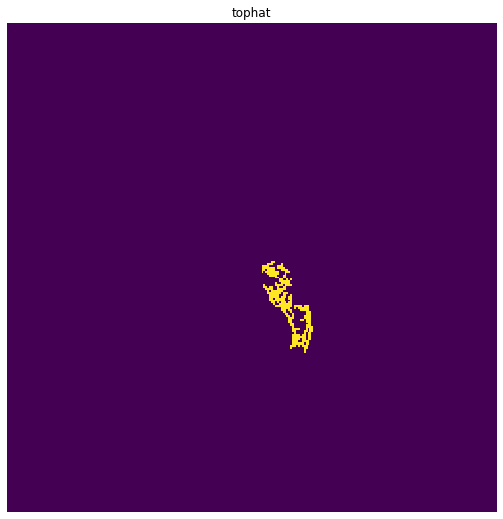

In [8]:
# tophat
kernel = np.ones((5, 5), np.uint8)
tophat = cv2.morphologyEx(gauss, cv2.MORPH_TOPHAT, kernel)

foreground_value = 255
mask_gradient = np.uint8(tophat == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask_gradient, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
top = np.zeros_like(tophat)
top[labels == largest_label] = foreground_value
ShowImage('tophat',top,'rgb')

# tophat dari invers

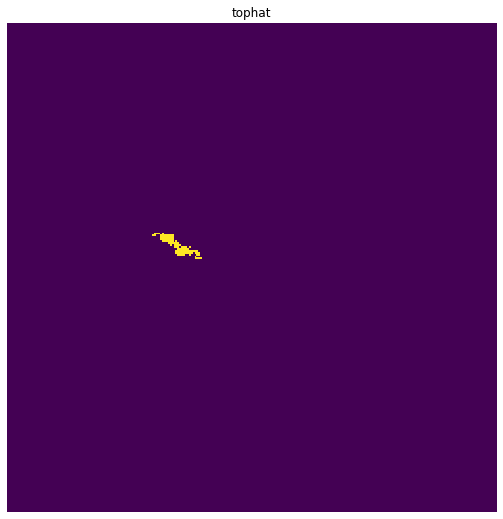

In [9]:
# tophat
kernel = np.ones((5, 5), np.uint8)
tophat = cv2.morphologyEx(invers, cv2.MORPH_TOPHAT, kernel)

foreground_value = 255
mask_gradient = np.uint8(tophat == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask_gradient, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
top_invers = np.zeros_like(tophat)
top_invers[labels == largest_label] = foreground_value
ShowImage('tophat',top_invers,'rgb')

# dilation from tophat

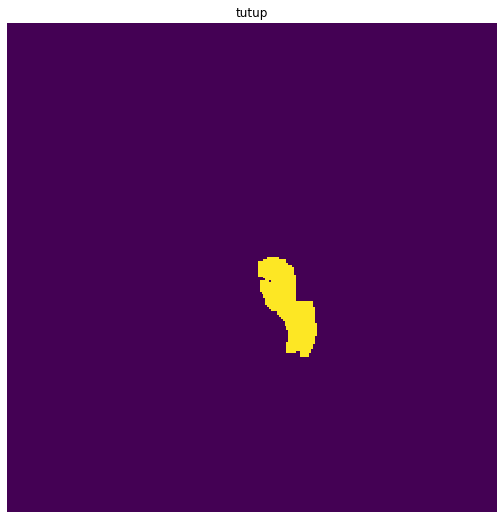

In [10]:
bentukan = np.ones((5, 5), np.uint8)
dilasi = cv2.dilate(top,bentukan,iterations = 1)

foreground_value = 255
mask_dilasi = np.uint8(dilasi >= foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
tutup = np.zeros_like(dilasi)
tutup[labels == largest_label] = foreground_value
ShowImage('tutup',tutup,'rgb')


# dilation from top invers

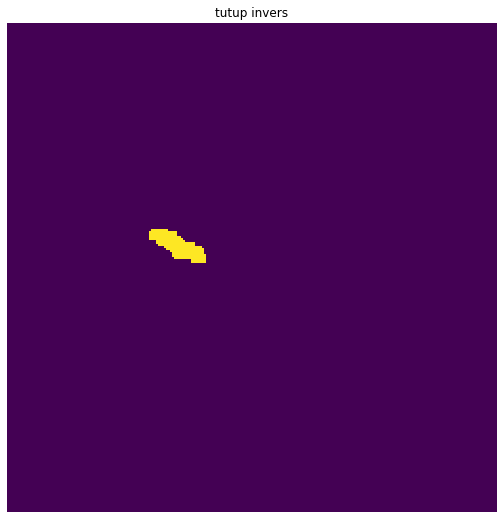

In [11]:
bentukan = np.ones((5, 5), np.uint8)
dilasi = cv2.dilate(top_invers,bentukan,iterations = 1)

foreground_value = 255
mask_dilasi = np.uint8(dilasi >= foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
tutup_invers = np.zeros_like(dilasi)
tutup_invers[labels == largest_label] = foreground_value
ShowImage('tutup invers',tutup_invers,'rgb')


# Skull Stripping

In [12]:
img_2d = file.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

#Skull Stripping
skull_stripped_image = cv2.bitwise_and(
    hasil, hasil, mask = tutup)
brain_pixels = skull_stripped_image[tutup == foreground_value]
print (brain_pixels, 'Brain Pixels')

# Adapting the data to K-means
kmeans_input = np.float32(brain_pixels.reshape(
    brain_pixels.shape[0], brain_pixels.ndim))
print(kmeans_input, 'Kmeans Input')

# K-means parameters
epsilon = 0.01
number_of_iterations = 50
number_of_clusters = 4
number_of_repetition = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            number_of_iterations, epsilon)
flags = cv2.KMEANS_RANDOM_CENTERS
print(criteria, 'criteria Paramaters')

# K-means segmentation
_, labels, centers = cv2.kmeans(
    kmeans_input, number_of_clusters, None, criteria,
    number_of_repetition, flags)
print(labels.shape, 'K-means segmentation')

# Adapting the labels
labels = labels.flatten('F')
for x in range(number_of_clusters):
    labels[labels == x] = centers[x]

[44 42 38 36 38 43 51 43 33 36 41 39 35 45 48 46 55 59 44 41 43 41 40 40
 40 45 46 41 37 38 45 50 54 42 34 36 36 39 45 47 46 39 36 37 41 44 40 49
 60 45 40 42 46 46 43 40 41 38 38 46 45 43 42 45 50 48 49 46 39 46 49 47
 51 44 45 45 40 45 45 48 48 40 41 49 54 57 47 38 44 42 40 50 50 52 47 39
 38 39 45 45 46 49 52 47 51 40 38 42 41 43 46 45 45 44 50 51 41 39 40 50
 52 44 36 40 41 38 41 37 36 44 53 50 45 43 44 39 36 42 46 40 37 40 45 42
 36 40 41 39 42 48 49 50 48 41 42 40 46 44 38 43 47 48 50 47 48 45 44 49
 52 49 44 42 43 47 45 41 42 43 49 52 49 50 52 56 53 43 42 46 45 41 42 44
 41 46 50 51 44 40 43 46 48 50 44 43 43 47 47 44 46 50 47 44 46 46 44 41
 41 47 46 47 46 47 48 43 42 46 48 52 49 49 44 45 47 34 41 44 46 45 47 49
 50 48 47 47 48 44 46 46 48 47 48 50 22 35 44 44 43 50 52 44 43 45 40 44
 47 46 44 42 40 45 49 18 26 38 44 45 47 50 43 43 48 46 47 49 46 43 40 44
 52 52 16 18 27 41 46 42 50 52 48 50 53 48 43 44 45 42 47 51 52 18 21 33
 46 49 49 48 50 49 46 44 47 47 46 44 45 49 52 20 30

# Segmented image

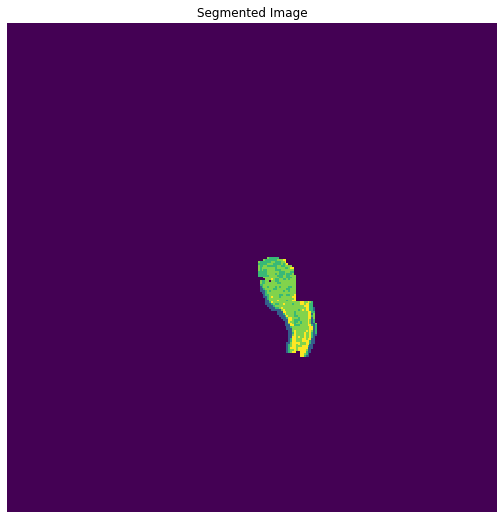

In [13]:
segmented_image = np.zeros_like(tutup)
segmented_image[tutup == foreground_value] = labels
ShowImage('Segmented Image',segmented_image,'rgb')

# All in One Row

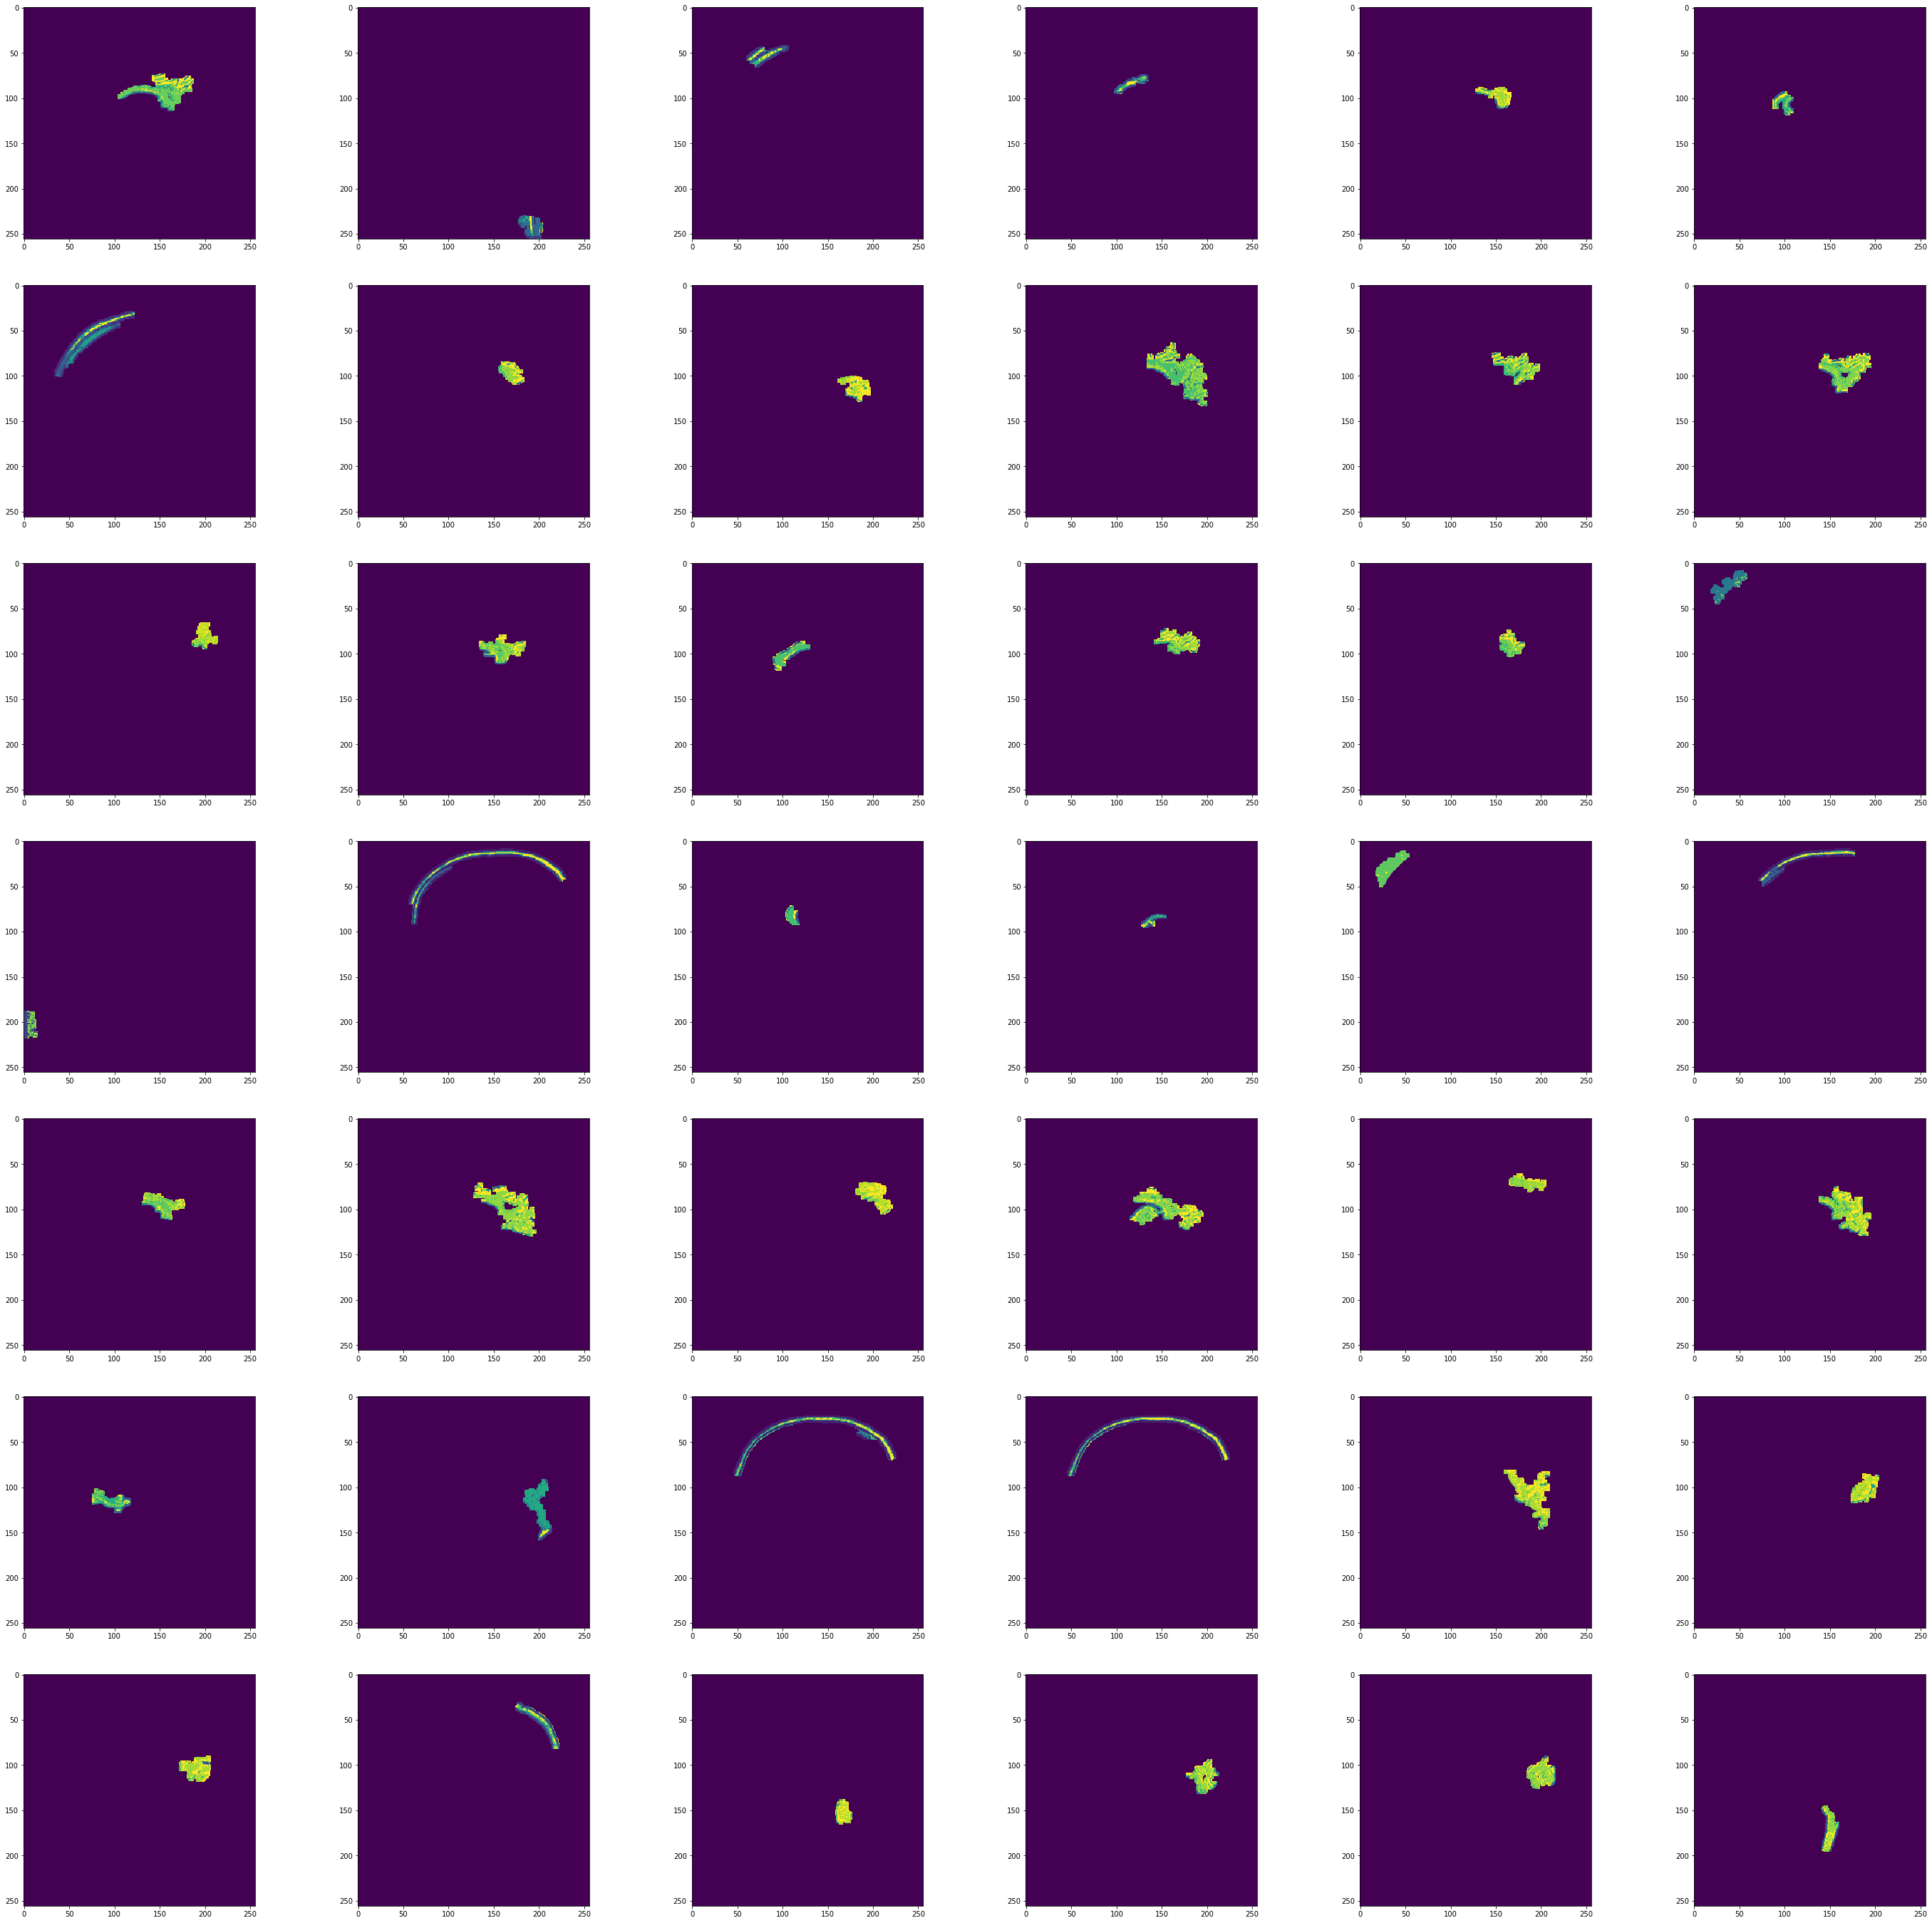

In [18]:
basepath ="../dicom/"
IMAGE_PATHS = os.listdir("../dicom/")
list_a = []

for f in IMAGE_PATHS:
    d = pydicom.read_file(basepath+f)
    a = np.array(d.pixel_array)
    
    img_2d = a.astype(float)
    img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
    img_2d_scaled = np.uint8(img_2d_scaled)
    hasil = img_2d_scaled
    
    gaussian = cv2.adaptiveThreshold(hasil,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,115, 1)

    foreground_value = 255
    mask_gaussian = np.uint8(gaussian == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_gaussian, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    gauss = np.zeros_like(gaussian)
    gauss[labels == largest_label] = foreground_value
    
    # tophat
    kernel = np.ones((5, 5), np.uint8)
    tophat = cv2.morphologyEx(gauss, cv2.MORPH_TOPHAT, kernel)

    foreground_value = 255
    mask_gradient = np.uint8(tophat == foreground_value)
    
    labels, stats = cv2.connectedComponentsWithStats(mask_gradient, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    top = np.zeros_like(tophat)
    top[labels == largest_label] = foreground_value
    
    bentukan = np.ones((5, 5), np.uint8)
    dilasi = cv2.dilate(top,bentukan,iterations = 1)

    foreground_value = 255
    mask_dilasi = np.uint8(dilasi >= foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    tutup = np.zeros_like(dilasi)
    tutup[labels == largest_label] = foreground_value
    
    
    #Skull Stripping
    skull_stripped_image = cv2.bitwise_and(hasil, hasil, mask = tutup)
    brain_pixels = skull_stripped_image[tutup == foreground_value]

    # Adapting the data to K-means
    kmeans_input = np.float32(brain_pixels.reshape(brain_pixels.shape[0], brain_pixels.ndim))

    # K-means parameters
    epsilon = 0.01
    number_of_iterations = 50
    number_of_clusters = 4
    number_of_repetition = 10
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,number_of_iterations, epsilon)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # K-means segmentation
    _, labels, centers = cv2.kmeans(kmeans_input, number_of_clusters, None, criteria,number_of_repetition, flags)

    # Adapting the labels
    labels = labels.flatten('F')
    for x in range(number_of_clusters):
        labels[labels == x] = centers[x]
        
    segmented_image = np.zeros_like(tutup)
    segmented_image[tutup == foreground_value] = labels
        
    list_a.append(segmented_image)
    
fig=plt.figure(figsize=(49, 49))
columns = 6
rows = 7
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(list_a[i])
plt.show()